In [25]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2

In [26]:
def load_img(path, bw=False, width=200, height=200):
  img = cv2.imread(path)
  if bw:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  if width and height:
    try:
        img = cv2.resize(img, (height, width), interpolation=cv2.INTER_LINEAR)
    except Exception as e:
        print(path)
    
  return img

In [27]:
dataset_list = []

for i in range(2597, 2817):
    if i != 2713 and i != 2762:
        img = load_img(f'./dataset/IMG_{i}.jpg', width=500, height=500)
        dataset_list.append(img)

dataset = np.array(dataset_list)

In [28]:
# to try with small section
dataset1 = np.array(dataset_list[:11])
frames = np.array(dataset1) / 255.
numFrames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

In [29]:
def magnify_frames(frames, magnificationFactor=10, sigma=13, alpha=0.5):
  # we will magnify windows of the video and aggregate the results
  magnified = np.zeros_like(frames)

  # meshgrid for computing Gaussian window
  X, Y = np.meshgrid(np.arange(width), np.arange(height))

  # iterate over windows of the frames
  xRange = list(range(0, width, 2*sigma))
  yRange = list(range(0, height, 2*sigma))
  numWindows = len(xRange) * len(yRange)
  windowIndex = 1

  for y in yRange:
      for x in xRange:
          for channelIndex in range(3): # RGB channels
              for frameIndex in range(numFrames):
                  
                  # create windowed frames
                  diff = ( x - X ) ** 2 + ( y - Y ) ** 2
                  gaussianMask = np.exp(-diff / (2*sigma**2)) / (1 / np.sqrt(2*np.pi * sigma ** 2))
                  windowedFrames = gaussianMask * frames[frameIndex,:,:,channelIndex]
              
                  # initialize moving average of phase for current window/channel
                  if frameIndex == 0:
                      windowAveragePhase = angle(fft2(windowedFrames))
                  
                  windowDft = fft2(windowedFrames)
                  
                  # compute phase shift and constrain to [-pi, pi] since
                  # angle space wraps around
                  windowPhaseShift = angle(windowDft) - windowAveragePhase
                  windowPhaseShift[windowPhaseShift > pi] = windowPhaseShift[windowPhaseShift > pi] - 2 * pi
                  windowPhaseShift[windowPhaseShift < -pi] = windowPhaseShift[windowPhaseShift < -pi] + 2 * pi
                  
                  # magnify phase shift
                  windowMagnifiedPhase = windowAveragePhase + windowPhaseShift * magnificationFactor
                  
                  # go back to image space
                  windowMagnifiedDft = abs(windowDft) * np.exp(windowMagnifiedPhase*1j) 
                  windowMagnified = abs(ifft2(windowMagnifiedDft))
                  
                  # update moving average
                  windowPhaseUnwrapped = windowAveragePhase + windowPhaseShift
                  windowAveragePhase = alpha * windowAveragePhase + (1 - alpha) * windowPhaseUnwrapped
                  
                  # aggregate
                  magnified[frameIndex,:,:,channelIndex] = magnified[frameIndex,:,:,channelIndex] + windowMagnified
          
  return magnified

In [30]:
magnified = magnify_frames(frames)

In [31]:
outputs = magnified / np.max(magnified)
for channelIndex in range(3):
    originalFrame = frames[0,:,:,channelIndex]
    magnifiedFrame = outputs[0,:,:,channelIndex]
    scale = np.std(originalFrame[:]) / np.std(magnifiedFrame[:])
    originalMean = np.mean(originalFrame[:])
    magnifiedMean = np.mean(magnifiedFrame[:])
    outputs[:,:,:,channelIndex] = magnifiedMean + scale * (outputs[:,:,:,channelIndex] - magnifiedMean)

outputs = np.clip(outputs, 0, 1)

In [32]:
def imshow(im, cmap='gray', clip=False):
    # clip image from 0-1
    if clip:
        im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

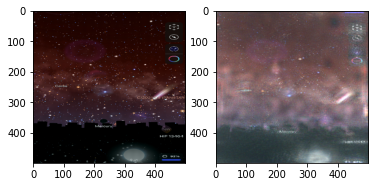

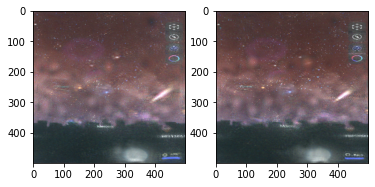

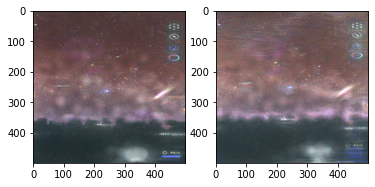

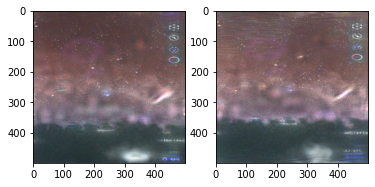

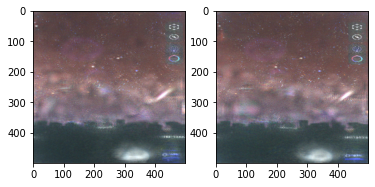

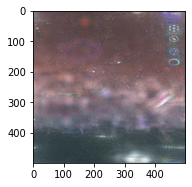

In [33]:
for i in range(outputs.shape[0]):
  if i % 2 == 0:
    plt.figure()
    plt.subplot(121)
  else:
    plt.subplot(122)
  imshow(outputs[i])